In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats

from scipy import ndimage
import numpy as np
import emd

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Helper function for the second level sift
def mask_sift_second_layer(IA, masks, config={}):
    imf2 = np.zeros((IA.shape[0], IA.shape[1], config['max_imfs']))
    for ii in range(IA.shape[1]):
        config['mask_freqs'] = masks[ii:]
        tmp = emd.sift.mask_sift(IA[:, ii], **config)
        imf2[:, ii, :tmp.shape[1]] = tmp
    return imf2

def get_holo_trl(filename, sys_type):
    raw=mne.io.read_raw_fif(filename)

    if sys_type == 'A':
        ag_num = [13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 46, 48, 56, 57, 58, 60, 61, 62, 63, 64, 74, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 110, 112, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]

    if sys_type == 'B':
        ag_num = [9, 13, 15, 16, 17, 18, 20, 21, 22, 25, 26, 27, 29, 30, 31, 33, 34, 49, 50, 58, 59, 60, 61, 62, 63, 64, 76, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 110, 114, 121, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]

    ag_names = ['AG%.3d'%s for s in ag_num]
    ag_picks = mne.pick_channels(raw.ch_names, ag_names)

    # find alpha
    freqs_sig = 9, 12
    freqs_noise = 8, 13

    epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False)
    epochs.drop_bad(reject = dict(mag=3e-12))      # unit: T (magnetometers)

    ssd = SSD(info=raw.info,
              reg='oas',
              sort_by_spectral_ratio=False,  # False for purpose of example.
              n_components = 5,
              picks = ag_picks,
              filt_params_signal=dict(l_freq=freqs_sig[0], h_freq=freqs_sig[1],
                                      l_trans_bandwidth=1, h_trans_bandwidth=1),
              filt_params_noise=dict(l_freq=freqs_noise[0], h_freq=freqs_noise[1],
                                     l_trans_bandwidth=1, h_trans_bandwidth=1))
    ssd.fit(X=epochs.get_data())

    pattern = mne.EvokedArray(data=ssd.patterns_[:4].T,
                              info=ssd.info)
    pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

    idx = np.argmax(np.abs(ssd.patterns_[0]))
    name_ = raw.info['ch_names'][idx]
    epochs.load_data()
    x = epochs.copy().pick_channels([name_]).get_data()
    x = np.squeeze(x) * 1e+15
    x.shape

    n_trl = epochs.get_data().shape[0]
    sholo_temp = np.zeros((n_trl, 256, 128))

    sample_rate = np.int(raw.info['sfreq'])
    config = emd.sift.get_config('mask_sift')
    config['max_imfs'] = 7
    config['mask_freqs'] = 50/sample_rate
    config['mask_amp_mode'] = 'ratio_sig'
    config['imf_opts/sd_thresh'] = 0.05

    # Carrier frequency histogram definition
    carrier_hist = (1, 100, 256, 'log')
    # AM frequency histogram definition
    am_hist = (1e-2, 32, 128, 'log')

    for n in range(n_trl):
        imf = emd.sift.mask_sift(x[n], **config)
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
        masks = np.array([25/2**ii for ii in range(12)])/sample_rate
        config = emd.sift.get_config('mask_sift')
        config['mask_amp_mode'] = 'ratio_sig'
        config['mask_amp'] = 2
        config['max_imfs'] = 5
        config['imf_opts/sd_thresh'] = 0.05
        config['envelope_opts/interp_method'] = 'mono_pchip'

        # Sift the first 5 first level IMFs
        imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

        IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')
        fcarrier, fam, holo = emd.spectra.holospectrum(IF[:,0:6], IF2[:,0:6,:], IA2[:,0:6,:], carrier_hist, am_hist)
        sholo = ndimage.gaussian_filter(holo, 1)

        sholo_temp[n] = sholo
        pass

    sholo_m = np.squeeze(np.nanmean(sholo_temp, axis = 0))
    return sholo_m, fam, fcarrier


def get_psd_median(s, group, sys_type):
    filename = 'de_hokuto_%s%d-raw.fif'%(group, s)
    raw=mne.io.read_raw_fif(filename)

    if sys_type == 'A':
        ag_num = [13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 46, 48, 56, 57, 58, 60, 61, 62, 63, 64, 74, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 110, 112, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]

    if sys_type == 'B':
        ag_num = [9, 13, 15, 16, 17, 18, 20, 21, 22, 25, 26, 27, 29, 30, 31, 33, 34, 49, 50, 58, 59, 60, 61, 62, 63, 64, 76, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 110, 114, 121, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]

    ag_names = ['AG%.3d'%s for s in ag_num]
    ag_picks = mne.pick_channels(raw.ch_names, ag_names)

    raw.pick(ag_picks)



    epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False)
    epochs.drop_bad(reject = dict(mag=3e-12))      # unit: pT (magnetometers)
    psd, freq_ = mne.time_frequency.psd_array_welch(epochs.get_data() * 1e+15, 
                                                    epochs.info['sfreq'], 
                                                    fmin=0, fmax=40, 
                                                    n_fft=256, average='mean')

    psd_M=np.expand_dims(psd[0].mean(axis = 1),axis=1)
    psd_evk=mne.EvokedArray(psd_M,epochs.info,comment='raw_data')
    #psd_evk.plot_topomap(times=0,ch_type='mag',scalings=dict(mag=1), extrapolate='head',sensors=False, contours=0)
    psd_median = np.sqrt(np.squeeze(np.median(psd.mean(axis=0), axis=0)))
    psd_mean = np.sqrt(np.squeeze(np.mean(psd.mean(axis=0), axis=0)))
    #plt.plot(freq_, psd_median, 'r', freq_, psd_mean, 'b')
    return  freq_, psd_median, psd_mean

In [183]:
%matplotlib qt

In [2]:
group = 'control'


sys_types = ['A','B','A','A','A','A','A','B','B','B','A',
             'A','A','B','A','A','B','B','B','B','A','A','B','A','A','A','A',
             'A','A','A','B','B','A','A','B','A','A','A','A','B','A','A','A',
             'A','A','A','A','A','B','A','A','A','A','A','A','A','B','A','A',
             'A','A','A','A','A','A','A','A','A','A','A','A','A','A','A','A',
             'A','B','B','B','A','A','A','A','A','A','A','A','B','A','B','A',
             'A','A','B','B','B','B','A','B','B']

excluded_control = []

psd_median_c = []
psd_mean_c = []
for i in range(100):
    s = i + 1
    sys_type = sys_types[i]
    try:
        freq_, psd_median, psd_mean = get_psd_median(s, group, sys_type)
        psd_median_c.append(psd_median)
        psd_mean_c.append(psd_mean)
    except:
        print('no id %d'%s)
        excluded_control.append(s)
    pass
    


no id 55
no id 68


In [3]:
 
group = 'dementia'


sys_types = ['A','B','A','B','A','B','B','B','B',
             'A','B','A','A','A','A','A','A','A',
             'A','B','A','B','A','A','B','A','A',
             'A','A']
excluded_dementia = []
psd_median_d = []
psd_mean_d = []
for i in range(29):
    s = i + 1
    sys_type = sys_types[i]
    try:
        freq_, psd_median, psd_mean = get_psd_median(s, group, sys_type)
        psd_median_d.append(psd_median)
        psd_mean_d.append(psd_mean)
    except:
        print('no id %d'%s)
        excluded_dementia.append(s)
    pass
    
    

 
 

no id 6
no id 27


In [4]:
 
group = 'mci'


sys_types = ['B','B','B','B','B','B','B','B','B',
             'B','A','B','B','B','B']
excluded_mci = []
psd_median_m = []
psd_mean_m = []
for i in range(15):
    s = i + 1
    sys_type = sys_types[i]
    try:
        freq_, psd_median, psd_mean = get_psd_median(s, group, sys_type)
        psd_median_m.append(psd_median)
        psd_mean_m.append(psd_mean)
    except:
        print('no id %d'%s)
        excluded_mci.append(s)
    pass
    
    

 
 

no id 6
no id 7


In [5]:
print(excluded_control)
print(excluded_dementia)
print(excluded_mci)
psd_mdn_d = np.vstack(psd_median_d)
psd_mdn_c = np.vstack(psd_median_c)
psd_mdn_m = np.vstack(psd_median_m)

psd_m_d = np.vstack(psd_mean_d)
psd_m_c = np.vstack(psd_mean_c)
psd_m_m = np.vstack(psd_mean_m)

[55, 68]
[6, 27]
[6, 7]


In [6]:
psd_mdn = np.concatenate((psd_mdn_c, psd_mdn_d, psd_mdn_m),axis=0)
psd_m = np.concatenate((psd_m_c, psd_m_d, psd_m_m),axis=0)

y = [0] * psd_mdn_c.shape[0] + [1] * psd_mdn_d.shape[0] + [2] * psd_mdn_m.shape[0]
y = np.array(y)
print(psd_m.shape)
print(len(y))

with open('feature_psd_80channel.npy', 'wb') as f:
    np.save(f, psd_mdn)
    np.save(f, psd_m)
    np.save(f, y)

(138, 21)
138


In [9]:

# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel="linear", class_weight={0: 1, 1: 10, 2:1})

scores = cross_validate(wclf, psd_mdn, y, cv=10, return_train_score=True)
print(scores['train_score'].mean())
print(scores['test_score'].mean())

0.8921096774193549
0.718131868131868


In [100]:
scores = cross_val_score(wclf, psd_m, y, cv=10)
scores.mean()

0.6862637362637363

In [10]:
X = psd_mdn

clf = MLPClassifier(solver='adam', learning_rate_init=0.001, max_iter=10000, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
clf.fit(X_train, y_train)
print("Training set score: %f" % clf.score(X_train, y_train))
print("Test set score: %f" % clf.score(X_test, y_test))


Training set score: 1.000000
Test set score: 0.857143


In [13]:
print(np.min(psd_mdn))
print(np.max(psd_mdn))

3.1404327723354255
105.84421176212841


In [20]:
X = psd_mdn

clf = MLPClassifier(hidden_layer_sizes=(256, 128, 32, 16, 8), solver='adam', learning_rate_init=0.001, max_iter=10000, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
clf.fit(X_train, y_train)
print("Training set score: %f" % clf.score(X_train, y_train))
print("Test set score: %f" % clf.score(X_test, y_test))

Training set score: 1.000000
Test set score: 0.821429


In [209]:
group = 'test'

sys_types = ['A','A','B','B','A','B','A','B','A',
             'A','B','A','A','A','A','B','B','A',
             'A','A','B','B','B','B','B','B','B',
             'B','B','B','A','A','B','B','A','A',
             'A','A','A','A','A','B']

excluded_test = []
psd_median_t = []
psd_mean_t = []
for i in range(42):
    s = i + 1
    sys_type = sys_types[i]
    try:
        freq_, psd_median, psd_mean = get_psd_median(s, group, sys_type)
        psd_median_t.append(psd_median)
        psd_mean_t.append(psd_mean)
    except:
        print('no id %d'%s)
        excluded_test.append(s)
    pass
    

no id 16


In [210]:
excluded_test

[16]

In [213]:
clf.predict(psd_median_t)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2])

In [214]:
clf.predict_proba(psd_median_t).round(3)

array([[0.985, 0.011, 0.005],
       [0.727, 0.101, 0.172],
       [0.983, 0.014, 0.003],
       [0.767, 0.232, 0.   ],
       [0.905, 0.007, 0.088],
       [0.797, 0.003, 0.2  ],
       [0.897, 0.102, 0.001],
       [1.   , 0.   , 0.   ],
       [0.002, 0.996, 0.002],
       [0.879, 0.042, 0.079],
       [0.157, 0.   , 0.843],
       [0.704, 0.296, 0.   ],
       [0.995, 0.   , 0.005],
       [0.   , 0.999, 0.001],
       [0.593, 0.407, 0.   ],
       [0.981, 0.017, 0.002],
       [1.   , 0.   , 0.   ],
       [0.395, 0.288, 0.317],
       [0.001, 0.998, 0.001],
       [0.619, 0.381, 0.   ],
       [0.979, 0.014, 0.007],
       [0.003, 0.997, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.387, 0.041, 0.572],
       [0.708, 0.217, 0.075],
       [0.987, 0.002, 0.011],
       [0.553, 0.005, 0.442],
       [0.999, 0.001, 0.001],
       [0.008, 0.   , 0.992],
       [0.037, 0.962, 0.   ],
       [0.   , 0.998, 0.002],
       [1.   , 0.   , 0.   ],
       [0.007, 0.993, 0.   ],
       [0.

In [200]:
filename = 'de_hokuto_%s%d-raw.fif'%('test', 16)
raw=mne.io.read_raw_fif(filename)

sys_type = 'B'

if sys_type == 'A':
    ag_num = [13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 46, 48, 56, 57, 58, 60, 61, 62, 63, 64, 74, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 110, 112, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]

if sys_type == 'B':
    ag_num = [9, 13, 15, 16, 17, 18, 20, 21, 22, 25, 26, 27, 29, 30, 31, 33, 34, 49, 50, 58, 59, 60, 61, 62, 63, 64, 76, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 110, 114, 121, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]

ag_names = ['AG%.3d'%s for s in ag_num]
ag_picks = mne.pick_channels(raw.ch_names, ag_names)

raw.pick(ag_picks)



epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False)
epochs.drop_bad(reject = dict(mag=5e-12))      # unit: pT (magnetometers)


Number of events,0
Events,1: 0
Time range,0.000 – 1.998 sec
Baseline,off


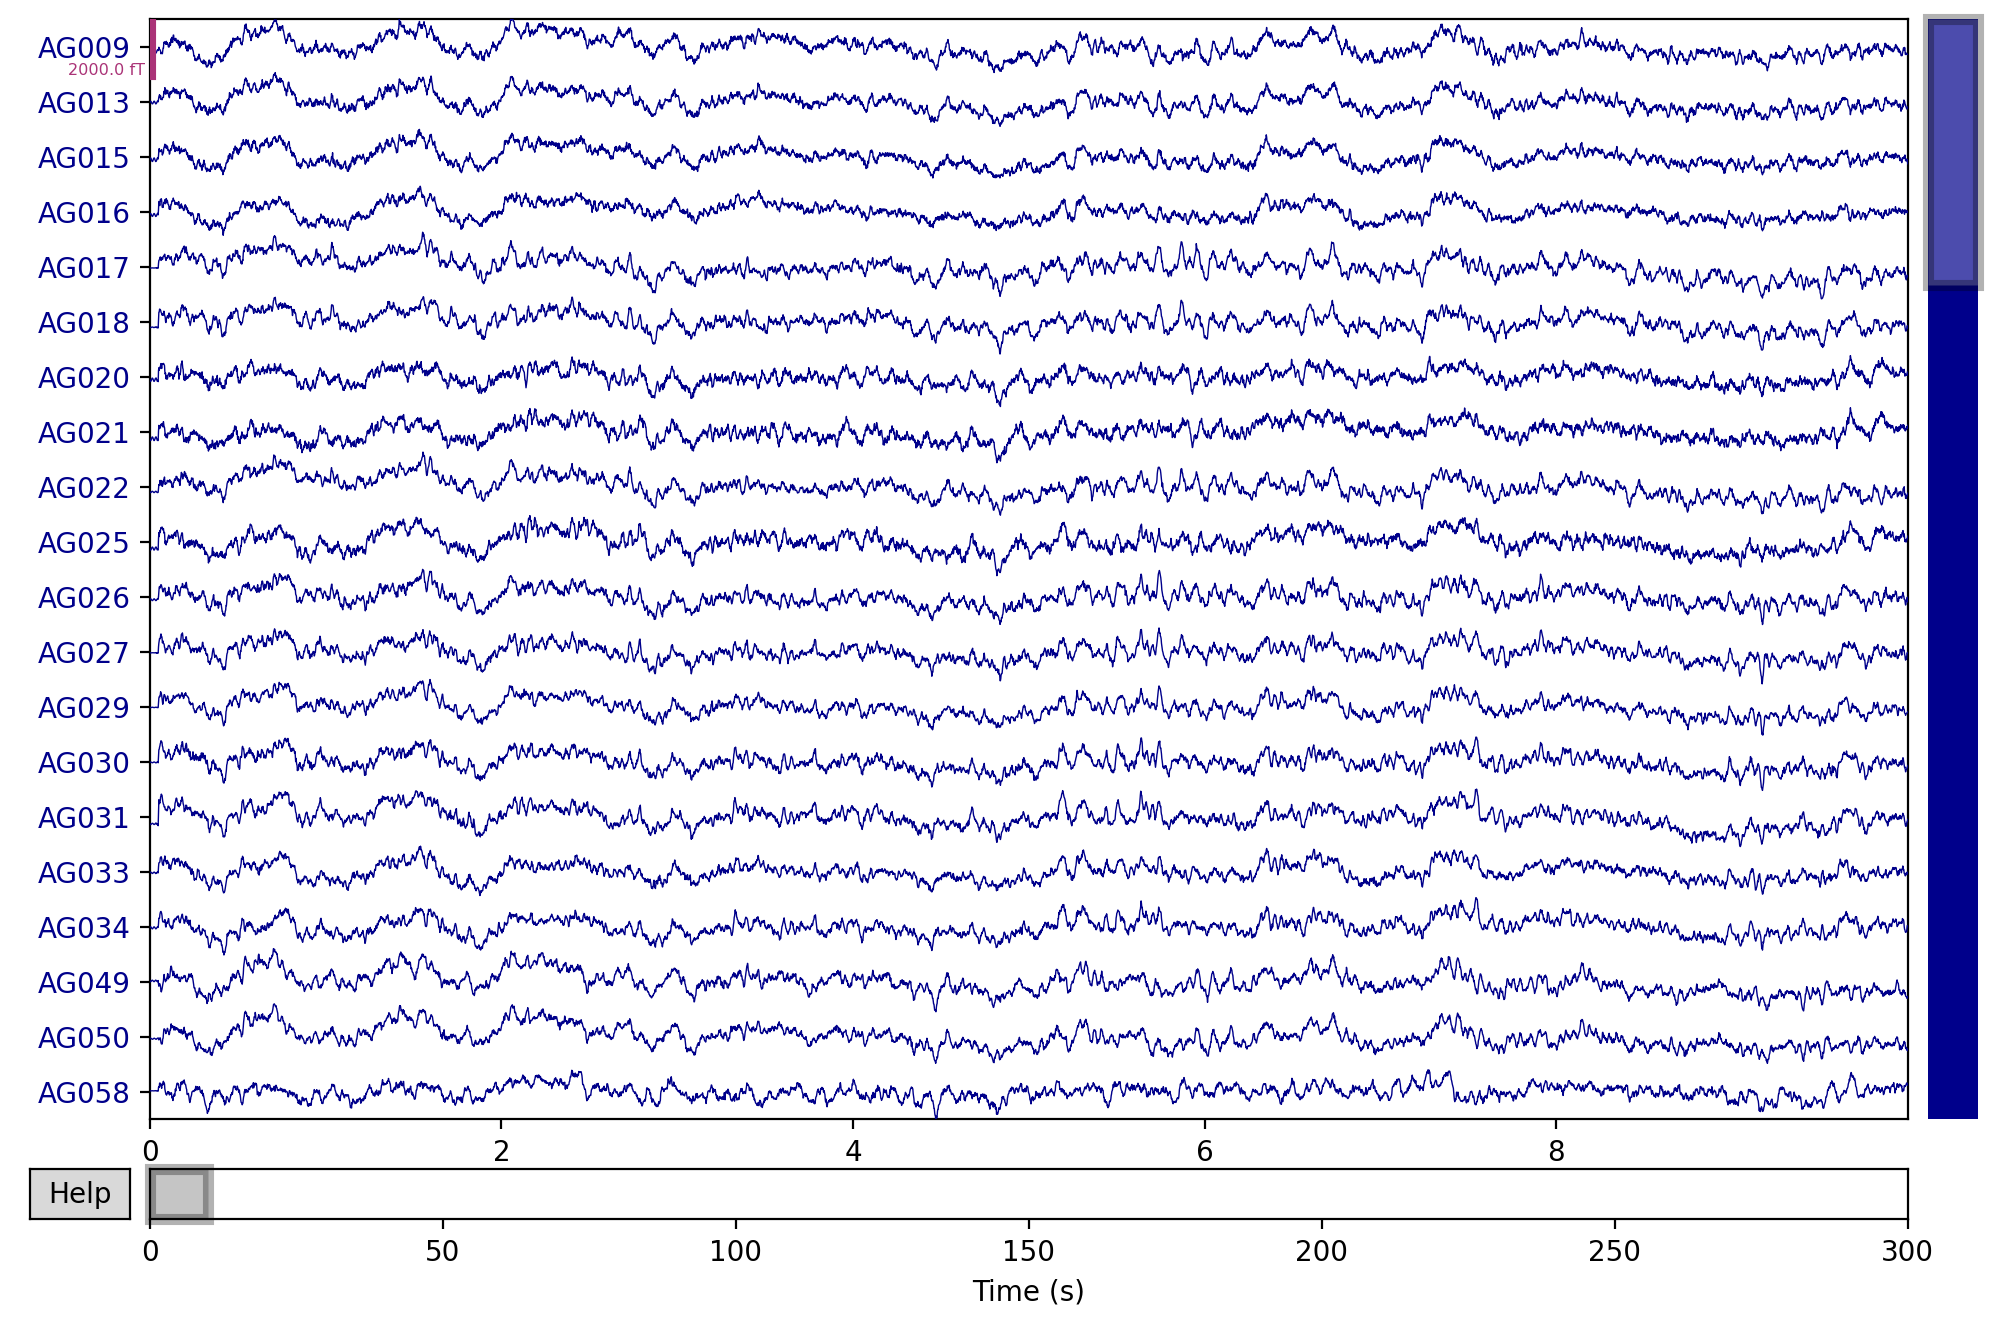

In [201]:
raw.plot()

In [220]:
print(raw.info['bads'])
raw.drop_channels(raw.info['bads'])

epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False)
epochs.drop_bad(reject = dict(mag=3e-12))      # unit: pT (magnetometers)
psd, freq_ = mne.time_frequency.psd_array_welch(epochs.get_data() * 1e+15, 
                                                epochs.info['sfreq'], 
                                                fmin=0, fmax=40, 
                                                n_fft=256, average='mean')

psd_M=np.expand_dims(psd[0].mean(axis = 1),axis=1)
psd_evk=mne.EvokedArray(psd_M,epochs.info,comment='raw_data')
psd_evk.plot_topomap(times=0,ch_type='mag',scalings=dict(mag=1), extrapolate='head',sensors=False, contours=0)
psd_median_1 = np.sqrt(np.squeeze(np.median(psd.mean(axis=0), axis=0)))

print(clf.predict([psd_median_1]))
print(clf.predict_proba([psd_median_1]).round(3))

[]
[1]
[[0. 1. 0.]]
